In [1]:
import math, time
import torch

In [2]:
import os
import sys
sys.path.append('../..')
from functions.get_data import data_n_loaders
LAB_DIR = os.environ['USERDIR']
DATA_PATH = LAB_DIR+'/data'
dataname = '2dgaussian_diffmag'
batch_size = 512
_, _,train_data, _, mean, scale = data_n_loaders(dataname, batch_size, return_data=True, \
      data_path=DATA_PATH, standardise_data = True, return_transform=True)
mean = mean.squeeze()
train_data_raw = (train_data.data/scale) + mean

/n/home00/sumedh/spmax_sae/experiments/expt19_separability_diffmag2/../../functions/get_data.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  file = torch.load(datapath)

In [3]:
torch.manual_seed(0)
#sample equal number of points from each class, get a decent subset of data
numpoints_perconcept = 1000
num_concepts = 6
data_subset_perconcept = []
labels_subset_perconcept = []
for i in range(num_concepts):
    indices = train_data.labels == i
    rand_indices_i = torch.randperm(indices.sum())[:numpoints_perconcept]
    data_subset_perconcept.append(train_data_raw[indices][rand_indices_i])
    labels_subset_perconcept.append(train_data.labels[indices][rand_indices_i])
data_subset_raw = torch.cat(data_subset_perconcept, dim=0)
data_subset = (data_subset_raw - mean) * scale #transform same as training data (to input to model)
labels_subset = torch.cat(labels_subset_perconcept, dim=0)

/tmp/ipykernel_3355314/3512491419.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data_k[:,0], data_k[:,1], c=colors_concept[num_concepts-1-k])


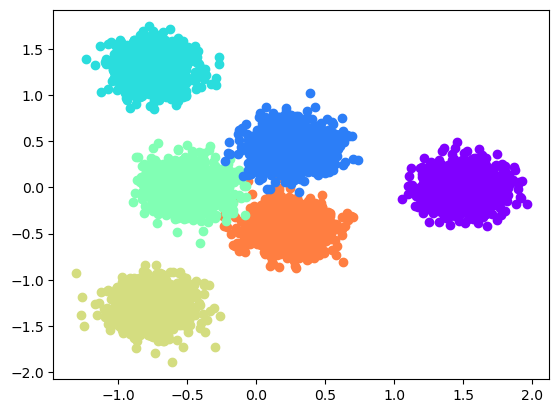

In [4]:
import matplotlib.pyplot as plt
# colors_concept = ['m', 'b', 'g', 'r', 'y']
#get 6 colors from cmap rainbow
cmap = plt.get_cmap('rainbow')
colors_concept = [cmap(i/num_concepts) for i in range(num_concepts)]
for k in range(num_concepts):
    data_k = data_subset_raw[labels_subset==(num_concepts-k-1),:]
    # plt.scatter(data_k[:,0], data_k[:,1], c=colors_concept[num_concepts-1-k])
    plt.scatter(data_k[:,0], data_k[:,1], c=colors_concept[num_concepts-1-k])
    # plt.xlim(-4, 8)
    # plt.ylim(-8, 6)

In [5]:
#get exptnames from folder names within saved_models
def get_exptnames():
    exptnames = []
    for root, dirs, files in os.walk('saved_models'):
        for dir in dirs:
            if 'checkpoints_' in dir:
                if ('gamreg' not in dir and 'topk' not in dir) or 'k15' in dir:
                    continue
                if 'w128' not in dir:
                    continue
                exptnames.append(dir.split('checkpoints_')[1])
    #sort exptnames to have all with same sae_type (name after the first _ within exptnames) together; after saename, the float following must be used for sorting
    order = {'relu': 0, 'jumprelu': 1, 'topk': 2, 'spade': 3}
    exptnames = sorted(exptnames, key=lambda x: (order[x.split('_')[1]]))
    return exptnames

In [6]:
#get sae_types from expt_names: it will be the string after first _, except for spade, which should be repaced by sparsemax_dist
def get_sae_types(exptnames):
    sae_types = []
    for exptname in exptnames:
        if 'spade' in exptname:
            sae_types.append('sparsemax_dist')
        elif 'topk_relu' in exptname:
            sae_types.append('topk_relu')
        else:
            sae_types.append(exptname.split('_')[1])
    return sae_types

In [7]:
exptnames = get_exptnames()
saetypes = get_sae_types(exptnames)
kvals_all = []
for exptname in exptnames:
    if 'topk' in exptname:
        kvals_all.append(int(exptname.split('_k')[1].split('_')[0]))
    else:
        kvals_all.append(0)
gammavals_all = []
for exptname in exptnames:
    if 'gamreg' in exptname:
        gammavals_all.append(float(exptname.split('_gamreg')[1].split('_')[0]))
    else:
        gammavals_all.append(0)

In [8]:
kvals_plot = [2*i for i in range(1, 11)]
gammavals_relu_plot = [1.0, 0.5, 0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05, 5e-06, 1e-06]
gammavals_jumprelu_plot = [0.1, 0.05, 0.005, 0.00125, 0.001, 0.0005, 0.0001, 5e-05, 1e-05, 5e-06]
gammavals_spade_plot = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05]

relu_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'relu' and gammavals_all[i] in gammavals_relu_plot]
jumprelu_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'jumprelu' and gammavals_all[i] in gammavals_jumprelu_plot]
topk_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'topk_relu' and kvals_all[i] in kvals_plot]
spade_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'sparsemax_dist' and gammavals_all[i] in gammavals_spade_plot]

numpoints_persae = len(relu_indices2)

allindices2 = relu_indices2 + jumprelu_indices2 + topk_indices2 + spade_indices2

In [9]:
exptnames = [exptnames[i] for i in allindices2]
saetypes = [saetypes[i] for i in allindices2]
kvals_all = [kvals_all[i] for i in allindices2]
gammavals_all = [gammavals_all[i] for i in allindices2]

In [10]:
from models import SAE
width = 128 #of sae
modelsall = []
dimdata = 2
for i in range(len(exptnames)):
    exptnamei = exptnames[i]
    normalize_decoder = False if saetypes[i] == 'sparsemax_dist' else True
    modeli = SAE(dimdata, width, sae_type=saetypes[i],kval_topk=kvals_all[i], normalize_decoder=normalize_decoder)
    state_dict = torch.load(f"./saved_models/checkpoints_{exptnamei}/model_8204epochs.pt")
    modeli.load_state_dict(state_dict['model'])
    modelsall.append(modeli)

/tmp/ipykernel_3355314/2221121231.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"./saved_models/checkpoints_{exptnamei}/model_8204epochs.pt")


In [11]:
#get latent representations on data subset
latent_reps_all = [] #latent reps on data subset for each model
mse_all = []
nmse_all = []
device = 'cuda'
for i in range(len(exptnames)):
    modeli = modelsall[i].to(device)
    with torch.no_grad():
        pts_recon, latent_reps = modeli(data_subset.to(device), return_hidden=True)
        mse = ((pts_recon - data_subset.to(device))**2).sum(dim=-1).mean().item()
        mean_norm2 = (data_subset**2).sum(dim=-1).mean().item()
        mse_all.append(mse)
        nmse_all.append(mse/mean_norm2)
        latent_reps_all.append(latent_reps.detach().cpu())

#get f1 score of each latent for each class
eps = 1e-12

f1_all = torch.zeros((len(exptnames), num_concepts, width))
precision_all = torch.zeros((len(exptnames), num_concepts, width))
recall_all = torch.zeros((len(exptnames), num_concepts, width))
l0_all = torch.zeros((len(exptnames)))

for i in range(len(exptnames)):
    latents_i = latent_reps_all[i]
    # threshold = torch.quantile(latents_i[latents_i>0.0].flatten(), 0.1) #10th percentile of data
    threshold = 1e-6
    l0_all[i] = (latents_i>threshold).sum(dim=-1).float().mean()
    for c in range(num_concepts):
        truepos = (latents_i[labels_subset==c,:]>threshold).sum(0).float()
        falsepos = (latents_i[labels_subset!=c,:]>threshold).sum(0).float()
        allpos = (labels_subset==c).sum().float()
        pospred = (latents_i>threshold).sum(0).float()
        precision = truepos/(pospred+eps)
        recall = truepos/(allpos+eps)
        f1 = 2*precision*recall/(precision+recall+eps)
        f1_all[i,c, :] = f1
        precision_all[i,c, :] = precision
        recall_all[i,c, :] = recall
monosemantic_latents = torch.argmax(f1_all, dim=-1)

ordered_latents = torch.argsort(f1_all, dim=-1, descending=True)
f1_sorted = torch.gather(f1_all, dim=-1, index=ordered_latents)
precision_sorted = torch.gather(precision_all, dim=-1, index=ordered_latents)
recall_sorted = torch.gather(recall_all, dim=-1, index=ordered_latents)

In [12]:
saes_order = ['relu', 'jumprelu', 'topk_relu', 'sparsemax_dist']

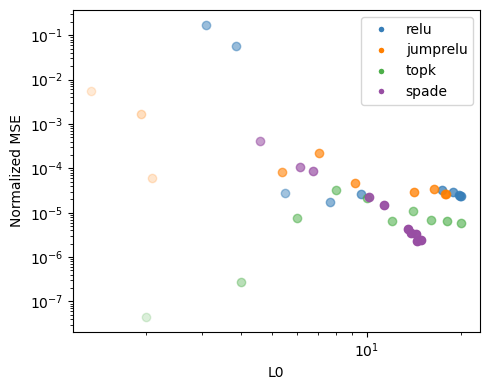

In [13]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(5, 4))

colors = ['#377eb8', '#ff7f00', '#4daf4a', '#984ea3']  # Define colors for different idsae values

for j in range(len(exptnames)):
    idsae = saes_order.index(saetypes[j])
    ax.scatter(l0_all[j], nmse_all[j], c=colors[idsae], alpha=f1_sorted[j,:,:5].mean().item())

ax.set_xlabel('L0')
ax.set_ylabel('Normalized MSE')
ax.set_xscale('log')
ax.set_yscale('log')
# Create custom legend

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[0], markersize=5, label='relu'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=5, label='jumprelu'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[2], markersize=5, label='topk'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[3], markersize=5, label='spade')
]

ax.legend(handles=legend_elements)
fig.tight_layout()
plt.show()

In [14]:
gammavals_saegrouped = []
for i in range(len(saes_order)):
    gammavals_saegrouped.append(sorted([gammavals_all[j] for j in range(len(exptnames)) if saetypes[j] == saes_order[i]]))
kvals_saegrouped = []
for i in range(len(saes_order)):
    kvals_saegrouped.append(sorted([kvals_all[j] for j in range(len(exptnames)) if saetypes[j] == saes_order[i]]))

l0_lineplot = torch.zeros((len(saes_order), numpoints_persae))
f1mean_lineplot = torch.zeros((num_concepts, len(saes_order), numpoints_persae))
f1std_lineplot = torch.zeros((num_concepts, len(saes_order), numpoints_persae))
shownum = 5
for i in range(num_concepts):
    for j in range(len(exptnames)):
        colid = saes_order.index(saetypes[j])  
        if saetypes[j] == 'topk_relu':
            l0id = kvals_saegrouped[colid].index(kvals_all[j])
        else:
            l0id = gammavals_saegrouped[colid].index(gammavals_all[j])
        l0_lineplot[colid, l0id] =  l0_all[j]
        f1mean_lineplot[i, colid, l0id] = f1_sorted[j, i, :shownum].mean()
        f1std_lineplot[i, colid, l0id] = f1_sorted[j, i, :shownum].std()


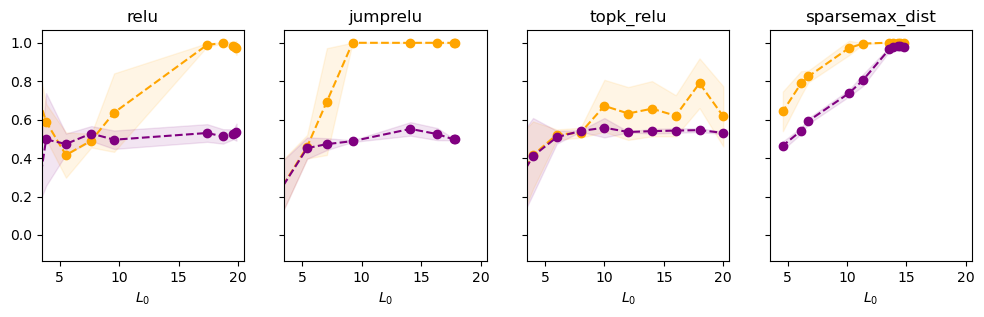

In [15]:
fig, ax = plt.subplots(1, len(saes_order), figsize=(3*len(saes_order), 3), sharey=True, sharex=True)

plot_concepts = [2,1]
concept_colors = ['orange', 'purple']
for k in range(len(plot_concepts)):
    for i in range(len(saes_order)):
        ax[i].fill_between(l0_lineplot[i, :], 
                   f1mean_lineplot[plot_concepts[k], i, :] - f1std_lineplot[plot_concepts[k], i, :], 
                   f1mean_lineplot[plot_concepts[k], i, :] + f1std_lineplot[plot_concepts[k], i, :], 
                   color=concept_colors[k], alpha=0.1)
        ax[i].plot(l0_lineplot[i, :], f1mean_lineplot[plot_concepts[k], i, :], 'o--', c=concept_colors[k])
        # ax[i].plot(l0_lineplot[i, :], f1mean_lineplot[plot_concepts[k],i, :], 'o--',c=concept_colors[k])
        ax[i].set_xlabel(r"$L_0$")
        ax[i].set_title(f"{saes_order[i]}")
        # ax[i].set_xscale('log')
        ax[i].set_xlim(3.5, 20.5)

In [16]:
xlims = [-2, 2]
ylims = [-2, 2]
numpoints_axis = 1000
x, y = torch.meshgrid(torch.linspace(xlims[0], xlims[1], numpoints_axis), torch.linspace(ylims[0], ylims[1], numpoints_axis))
Xmesh_raw = torch.stack([x, y], dim=2).view(-1, 2)
Xmesh = scale*(Xmesh_raw - mean.reshape((1, 2))) #transform to pass to the model
rfall = []
heatall = []

for i in range(len(exptnames)):
    with torch.no_grad():
        modeli = modelsall[i]
        _, latents = modeli(Xmesh.to(device), return_hidden=True)
        latents_s = latents.reshape((numpoints_axis, numpoints_axis, width)).T
        latents_s = latents_s.detach().cpu()
        rfall.append((latents_s>1e-6).float())
        heatall.append(latents_s)

/n/holylabs/LABS/ba_lab/Users/sumedh/conda/envs/spmax/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_3355314/2329087367.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  latents_s = latents.reshape((numpoints_axis, numpoints_axis, width)).T


In [17]:
exptnames_plot = []
plot_indices = []
for i in range(len(saes_order)):
    temp = f1mean_lineplot[plot_concepts, :,:].mean(dim=0)[i,:]
    index_l0_highestmeanf1 = temp.argmax().item()
    if saes_order[i] == 'topk_relu':
        l0_plot_index = kvals_saegrouped[i][index_l0_highestmeanf1]
        index_l0_saei = [j for j in range(len(exptnames)) if saetypes[j] == saes_order[i] and kvals_all[j] == l0_plot_index]
    else:
        l0_plot_index = gammavals_saegrouped[i][index_l0_highestmeanf1]
        index_l0_saei = [j for j in range(len(exptnames)) if saetypes[j] == saes_order[i] and gammavals_all[j] == l0_plot_index]
    assert len(index_l0_saei) == 1
    plot_indices.append(index_l0_saei[0])
    exptnames_plot.append(exptnames[index_l0_saei[0]])

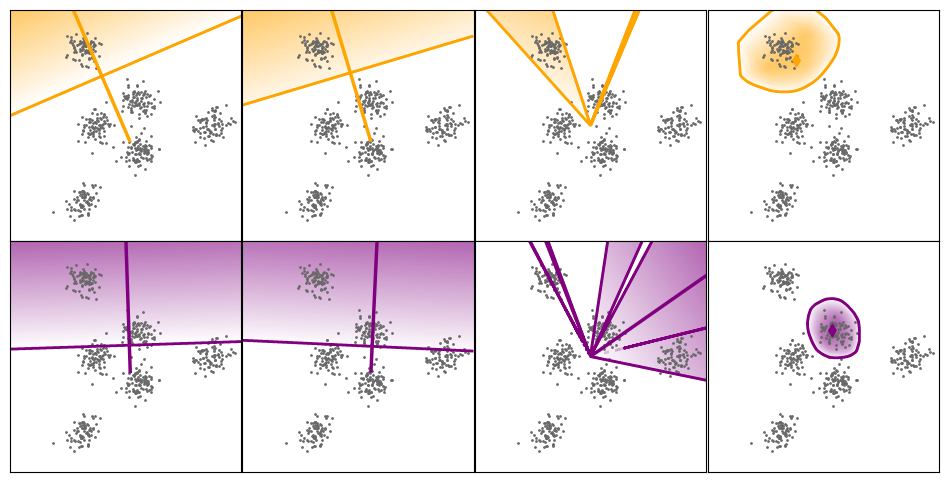

In [18]:
#show only final receptive fields for all models, data in separate figures, each having 4X5 subplots (one per neuron)
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 13})

fig, axs = plt.subplots(len(plot_concepts), len(exptnames_plot), figsize=(3*len(exptnames_plot), 3*len(plot_concepts)))
torch.manual_seed(0)
concept_names = ['Concept '+str(plot_concepts[i]) for i in range(len(plot_concepts))]
# colors_names = {'blue':'#377eb8', 'orange':'#ff7f00', 'green':'#4daf4a', 'red':'#e41a1c', 'purple':'#984ea3'}
# colors_concepts = [colors_names['green'], colors_names['blue'], colors_names['orange'], colors_names['purple'], colors_names['red']]
from matplotlib.colors import LinearSegmentedColormap
# Define a custom colormap that interpolates from white to your desired color
colormaps = []
for k in range(len(plot_concepts)):
    custom_cmap = LinearSegmentedColormap.from_list("custom", ["white", concept_colors[k]])
    colormaps.append(custom_cmap)
indices = torch.randperm(len(data_subset))[:500]
for j in range(len(exptnames_plot)):
    for k in range(len(plot_concepts)):
        axs[k,j].scatter(data_subset_raw[indices,0], data_subset_raw[indices,1], \
            s=1, c='dimgray')
        heatjk = heatall[plot_indices[j]][monosemantic_latents[plot_indices[j],plot_concepts[k]].item(),:,:]
        axs[k,j].imshow(heatjk, alpha=0.6,
            extent=[xlims[0], xlims[1], ylims[0], ylims[1]], origin='lower', cmap=colormaps[k])
        axs[k,j].set_xticks([])
        axs[k,j].set_yticks([])
        axs[k,j].set_xlim(*xlims)
        axs[k,j].set_ylim(*ylims)
        axs[k,j].contour(heatjk, levels=[torch.quantile(heatjk.flatten(), 0.1).item()], colors=concept_colors[k], \
            linewidths=2, extent=[xlims[0], xlims[1], ylims[0], ylims[1]])
        # if j==len(exptnames)-1: #sparsemax
        protos = modelsall[plot_indices[j]].Ae.detach().cpu()
        
        latentid = monosemantic_latents[plot_indices[j],plot_concepts[k]].item()
        if saetypes[plot_indices[j]] == 'sparsemax_dist':
            protos = protos/scale + mean
            axs[k,j].scatter(protos[latentid,0], protos[latentid,1], marker='d', color=concept_colors[k], s=40)
        else:
            protos = protos*scale
            protos = protos/(1e-12+ protos.norm(dim=1, keepdim=True))
            bdec = modelsall[plot_indices[j]].bd.detach().cpu().squeeze()
            bdec = bdec/scale + mean
            
            axs[k,j].quiver(bdec[0], bdec[1], protos[latentid,0], protos[latentid,1], scale=0.2, scale_units='xy', angles='xy', \
                color=concept_colors[k], width=0.015)
fig.subplots_adjust(wspace=0, hspace=0)
# plt.savefig("./figs/recfield_heatmaps.pdf", dpi=300, bbox_inches='tight')

plt.show()

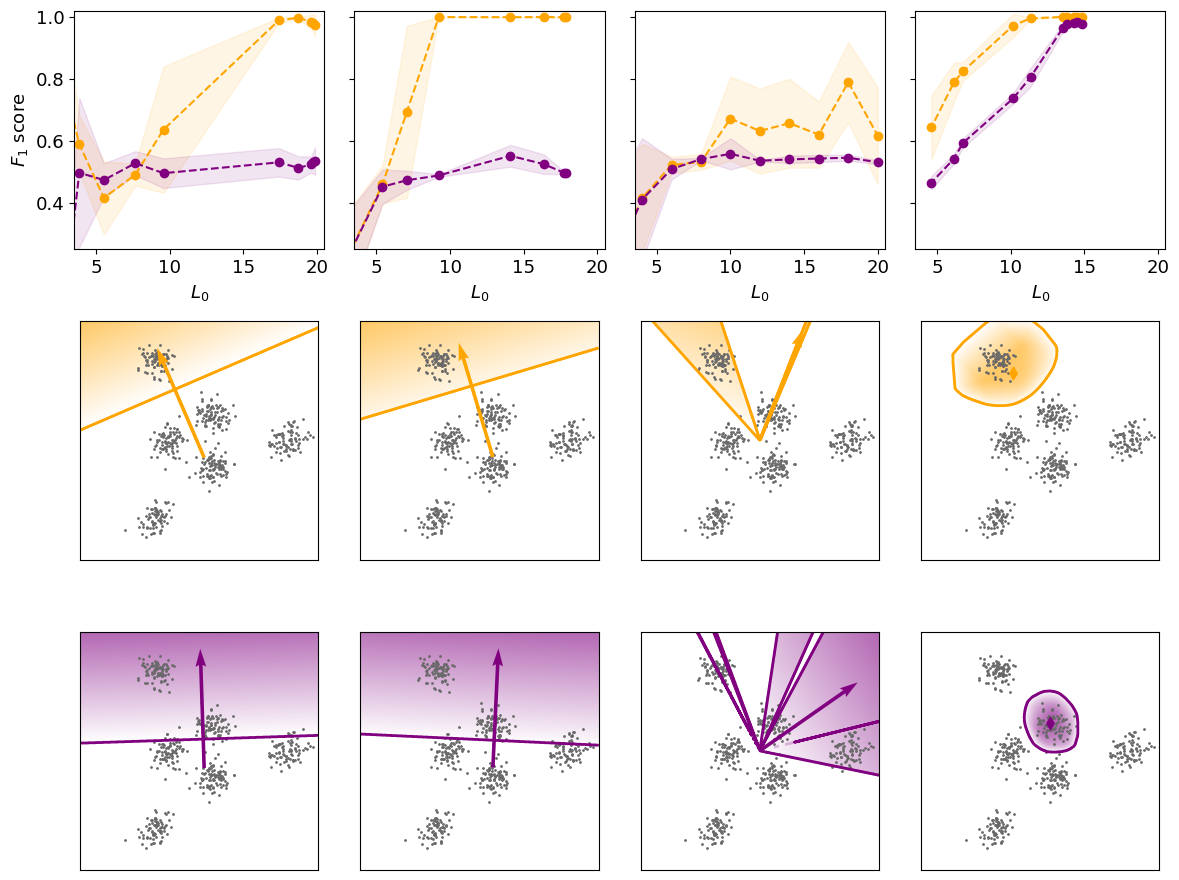

In [19]:
#show only final receptive fields for all models, data in separate figures, each having 4X5 subplots (one per neuron)
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 13})

fig, axs = plt.subplots(len(plot_concepts)+1, len(exptnames_plot), figsize=(3*len(exptnames_plot), 3*(1+len(plot_concepts))), sharey='row')
torch.manual_seed(0)
concept_names = ['Concept '+str(plot_concepts[i]) for i in range(len(plot_concepts))]
# colors_names = {'blue':'#377eb8', 'orange':'#ff7f00', 'green':'#4daf4a', 'red':'#e41a1c', 'purple':'#984ea3'}
# colors_concepts = [colors_names['green'], colors_names['blue'], colors_names['orange'], colors_names['purple'], colors_names['red']]
from matplotlib.colors import LinearSegmentedColormap
# Define a custom colormap that interpolates from white to your desired color
colormaps = []
for k in range(len(plot_concepts)):
    custom_cmap = LinearSegmentedColormap.from_list("custom", ["white", concept_colors[k]])
    colormaps.append(custom_cmap)
indices = torch.randperm(len(data_subset))[:500]
for j in range(len(exptnames_plot)):
    for k in range(len(plot_concepts)):
        axs[k+1,j].scatter(data_subset_raw[indices,0], data_subset_raw[indices,1], \
            s=1, c='dimgray')
        heatjk = heatall[plot_indices[j]][monosemantic_latents[plot_indices[j],plot_concepts[k]].item(),:,:]
        axs[k+1,j].imshow(heatjk, alpha=0.6,
            extent=[xlims[0], xlims[1], ylims[0], ylims[1]], origin='lower', cmap=colormaps[k])
        axs[k+1,j].set_xticks([])
        axs[k+1,j].set_yticks([])
        axs[k+1,j].set_xlim(*xlims)
        axs[k+1,j].set_ylim(*ylims)
        axs[k+1,j].contour(heatjk, levels=[torch.quantile(heatjk.flatten(), 0.1).item()], colors=concept_colors[k], \
            linewidths=2, extent=[xlims[0], xlims[1], ylims[0], ylims[1]])
        # if j==len(exptnames)-1: #sparsemax
        protos = modelsall[plot_indices[j]].Ae.detach().cpu()
        
        latentid = monosemantic_latents[plot_indices[j],plot_concepts[k]].item()
        if saetypes[plot_indices[j]] == 'sparsemax_dist':
            protos = protos/scale + mean
            axs[k+1,j].scatter(protos[latentid,0], protos[latentid,1], marker='d', color=concept_colors[k], s=40)
        else:
            protos = protos*scale
            protos = protos/(1e-12+ protos.norm(dim=1, keepdim=True))
            bdec = modelsall[plot_indices[j]].bd.detach().cpu().squeeze()
            bdec = bdec/scale + mean
            
            axs[k+1,j].quiver(bdec[0], bdec[1], protos[latentid,0], protos[latentid,1], scale=0.5, scale_units='xy', angles='xy', \
                color=concept_colors[k], width=0.015)
# fig.subplots_adjust(wspace=0, hspace=0)
# plt.savefig("./figs/recfield_heatmaps.pdf", dpi=300, bbox_inches='tight')

for k in range(len(plot_concepts)):
    for i in range(len(saes_order)):
        axs[0, i].fill_between(l0_lineplot[i, :], 
                   f1mean_lineplot[plot_concepts[k], i, :] - f1std_lineplot[plot_concepts[k], i, :], 
                   f1mean_lineplot[plot_concepts[k], i, :] + f1std_lineplot[plot_concepts[k], i, :], 
                   color=concept_colors[k], alpha=0.1)
        axs[0, i].plot(l0_lineplot[i, :], f1mean_lineplot[plot_concepts[k], i, :], 'o--', c=concept_colors[k])
        # ax[i].plot(l0_lineplot[i, :], f1mean_lineplot[plot_concepts[k],i, :], 'o--',c=concept_colors[k])
        axs[0, i].set_xlabel(r"$L_0$")
        # axs[0, i].set_title(f"{saes_order[i]}")
        # ax[i].set_xscale('log')
        if i==0:
            axs[0, i].set_ylabel(r"$F_1$ score")
        axs[0, i].set_xlim(3.5, 20.5)
        axs[0, i].set_ylim(0.25, 1.02)
fig.tight_layout()
plt.show()

## Get data-data, latent-latent corrs and compute stable rank

In [32]:
# f1_meanoverconc = f1_all.mean(dim=1)
# latents_order = torch.argsort(f1_meanoverconc, dim=-1, descending=True)
concept_of_latents = torch.zeros((len(exptnames), width))
for j in range(len(exptnames)):
    for i in range(width):
        concept_of_latents[j,i] = torch.argmax(f1_all[j, :, i])
latents_order = torch.argsort(concept_of_latents, dim=-1)

In [33]:
Cdatacos = []
Clatentcos = []
for i in range(len(exptnames)):
    
    latents = latent_reps_all[i][:,latents_order[i]]
    deadlatents = (latents>1e-12).sum(dim=0)==0.0
    latents = torch.cat([latents[:,~deadlatents], latents[:,deadlatents]], dim=1)
    Corr = latents @ latents.T
    norm = torch.norm(latents, dim=1).unsqueeze(1)
    Cdatacos.append( Corr/ (norm @ norm.T + 1e-12) )
    
    Corr = latents.T @ latents
    norm = torch.norm(latents, dim=0).unsqueeze(1)
    Corr = Corr/ (norm @ norm.T + 1e-12)
    Clatentcos.append(Corr)

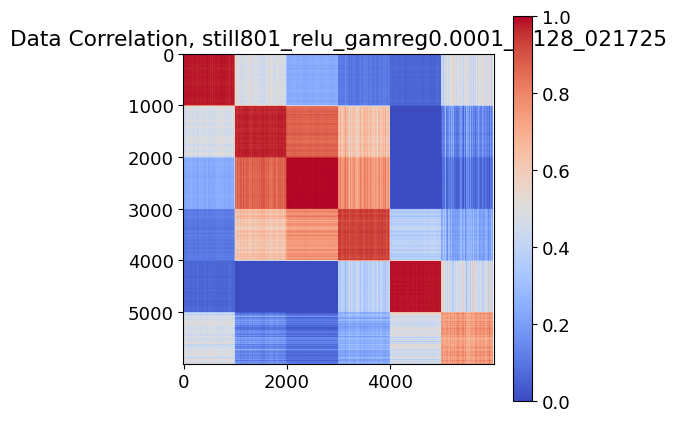

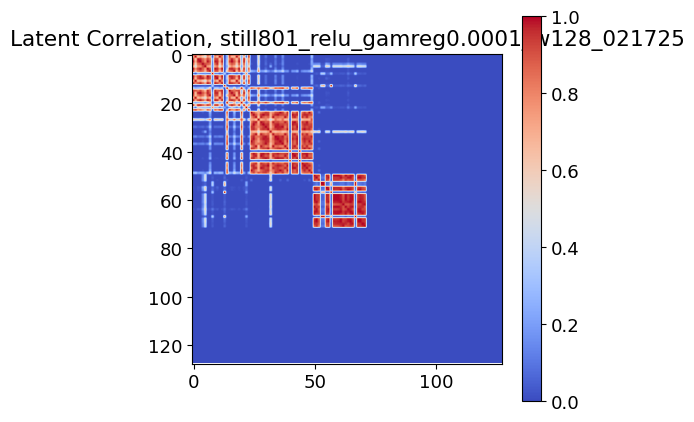

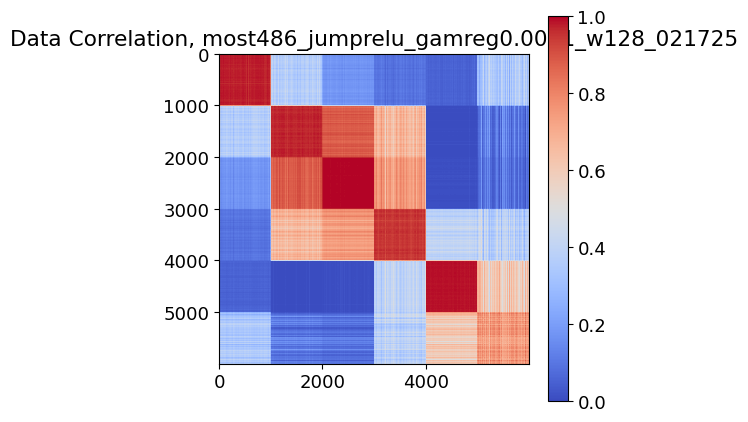

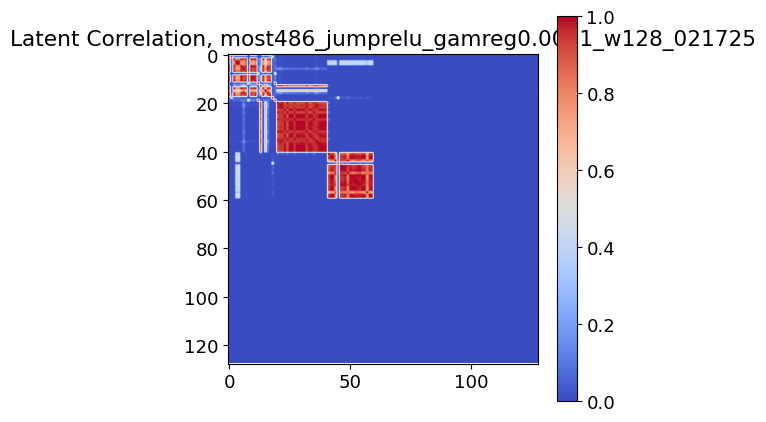

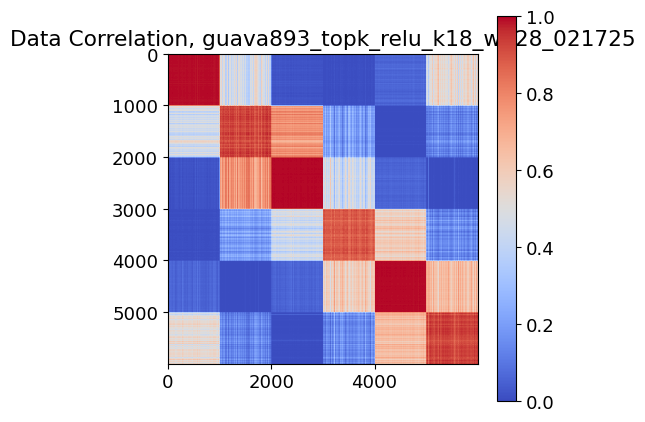

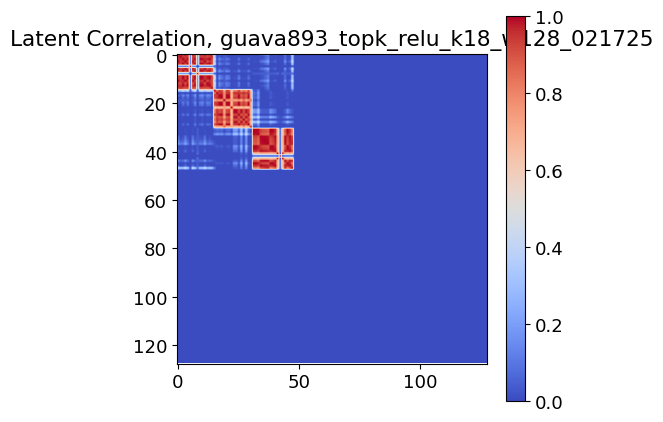

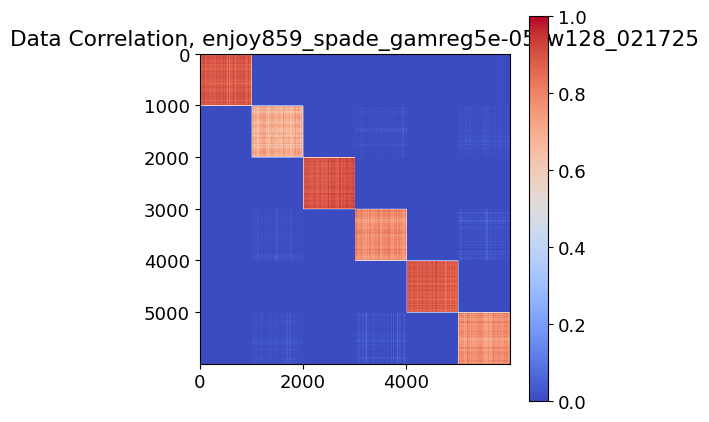

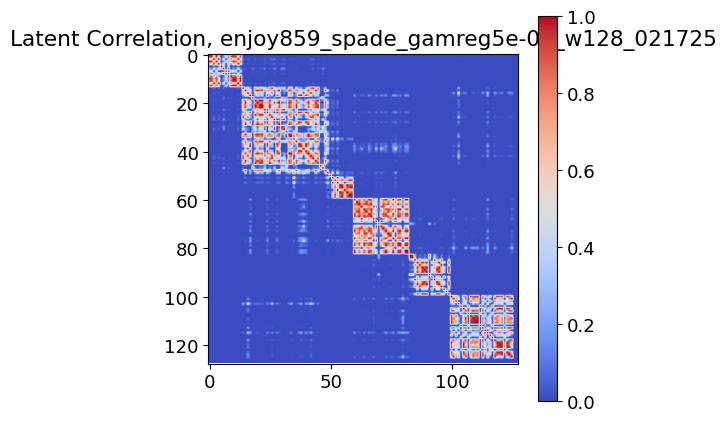

In [34]:
for i in range(len(exptnames_plot)):
    plt.figure(figsize=(5,5))
    plt.imshow(Cdatacos[plot_indices[i]], cmap='coolwarm', vmin=0, vmax=1)
    plt.colorbar()
    plt.title(f"Data Correlation, {exptnames_plot[i]}")
    plt.show()
    plt.figure(figsize=(5,5))
    plt.imshow(Clatentcos[plot_indices[i]], cmap='coolwarm', vmin=0, vmax=1)
    plt.colorbar()
    plt.title(f"Latent Correlation, {exptnames_plot[i]}")
    plt.show()